In [1]:
import os
os.chdir('../../')

In [2]:
!nvidia-smi

Tue Apr  1 01:45:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:19:00.0 Off |                  Off |
|  0%   57C    P8             37W /  350W |      11MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### from "sample pair.ipynb"

In [3]:
import torch
import torch.nn.functional as F

total_samples = 256
save_file = f'/data/optimization/euler_NFE=1000_N={total_samples}_imagenet128.pt'
data = torch.load(save_file)
noise = data['pairs'][:, 0]
target = data['pairs'][:, 1]
classes = data['classes']
print(noise.shape, target.shape)
print(classes)

torch.Size([256, 3, 128, 128]) torch.Size([256, 3, 128, 128])
tensor([348, 940, 965,  52,  47, 108, 901, 711, 168, 530,  67, 646, 855, 978,
         50, 578, 139, 527, 885, 979, 462, 100, 769, 805,  16, 501, 669, 560,
        276, 842, 946, 677, 354, 595, 792,  18, 394, 386, 345, 305, 854, 598,
        112, 851, 578, 720, 420, 136, 637, 929, 800, 921, 418, 549, 142, 929,
        178, 912, 738, 614, 243, 282, 646, 644, 174,  97, 567, 455, 766, 208,
        414, 152, 566, 621, 303, 891, 571, 361, 274, 159, 797, 125, 906, 163,
        348,  70, 361, 347, 186, 713, 204, 742, 578, 288, 354, 620, 959, 823,
        327, 358,  46, 860, 144, 402, 447,  99, 421, 623, 868, 140, 953, 670,
        184, 670, 993, 239, 907, 178, 377,  11, 803, 917, 338, 567, 217, 568,
        101, 368, 897, 571,  43, 639, 594, 764, 576, 992, 771, 734, 850, 814,
        538, 493,  67, 893, 909, 564, 210, 120, 779, 750, 386, 209, 976, 333,
        405, 886, 674, 598, 139, 615, 538,  54, 651, 264,  97, 870, 335,  71,
  

In [18]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import random

from main import parse_args_and_config, Diffusion
from datasets import inverse_data_transform

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.benchmark = False

###############################################################################
# 1) Notebook에서 sys.argv를 직접 설정 (argparse 흉내)
###############################################################################
sys.argv = [
    "main.py",
    "--config", "imagenet128_guided.yml",  # 사용하려는 config
    "--sample",
    "--eta", "0",
    "--dpm_solver_type", "data_prediction",
    "--dpm_solver_order", "3",
    "--skip_type", "logSNR",
    "--scale", "0.0",
    "--thresholding",
    "--ni",

    "--sample_type", "rbfsolverglq10lag",
    "--timesteps", "20",
    "--log_scale_min", "-2.0",
    "--log_scale_max", "3.0",
    "--log_scale_num", "1000",
    "--scale_dir", "/data/data/rbfsolverglq10lag",
]

###############################################################################
# 2) 인자/설정 로드
###############################################################################
args, config = parse_args_and_config()

###############################################################################
# 3) Diffusion 객체 생성 -> 모델 로딩
###############################################################################
diffusion = Diffusion(args, config, rank=0)
diffusion.prepare_model()
diffusion.model.eval()

###############################################################################
# 4) 배치(25장) 한 번에 샘플링 -> 5x5 그리드(여백 없이) 시각화
###############################################################################
device = diffusion.device


INFO - main.py - 2025-04-01 01:49:49,450 - Using device: cuda
INFO - main.py - 2025-04-01 01:49:49,450 - Using device: cuda
INFO - main.py - 2025-04-01 01:49:49,450 - Using device: cuda
INFO - main.py - 2025-04-01 01:49:49,450 - Using device: cuda


[prepare_model] Model is ready.


In [19]:
!mkdir /data/data/rbfsolverglq10lag
!ls /data/data/rbfsolverglq10lag

mkdir: cannot create directory ‘/data/data/rbfsolverglq10lag’: File exists
'NFE=10,p=3,dataset=IMAGENET128.npy'  'NFE=15,p=3,dataset=IMAGENET128.npy'
'NFE=10,p=3,dataset=IMAGENET64.npy'   'NFE=5,p=3,dataset=IMAGENET128.npy'


/data/data/rbfsolverglq10lag/NFE=20,p=3,dataset=IMAGENET128.npy  saved!
loss : tensor(0.0012, device='cuda:0')


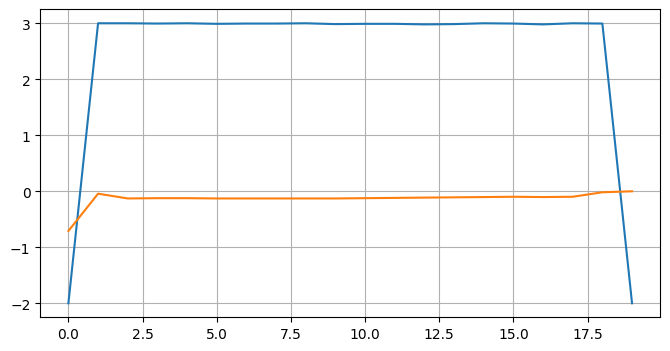

In [20]:
n = 64
start = 0
for _ in range(1):
    indexes = np.random.randint(0, len(noise), size=(n,))
    noise_batch = noise[indexes].to(device)
    target_batch = target[indexes].to(device)
    classes_batch = data['classes'][indexes].to(device)
    start += n

    #(pred, optimal_gammas, pred_losses_list, corr_losses_list), _ = diffusion.sample_image(noise_batch, diffusion.model, classifier=diffusion.classifier, target=target_batch)
    (pred, optimal_gammas, pred_losses_list, corr_losses_list, pred_coeffs_list, lag_coeffs_list), _ = diffusion.sample_image(noise_batch, diffusion.model, classes=classes_batch, target=target_batch)
    loss = F.mse_loss(pred, target_batch)
    print('loss :', loss)

    plt.figure(figsize=[8, 4])
    plt.plot(optimal_gammas[0])
    plt.plot(optimal_gammas[1])
    plt.grid()
    plt.show()


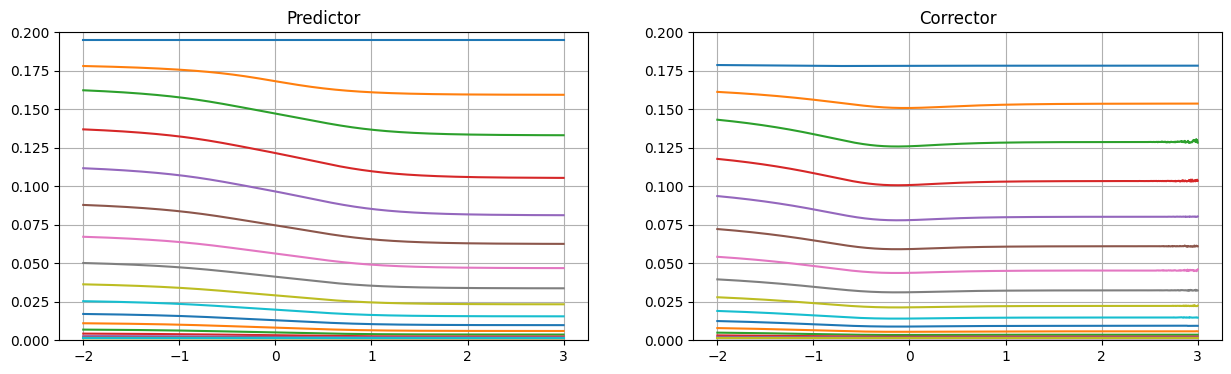

In [21]:
import matplotlib.pyplot as plt
x_axis = np.linspace(args.log_scale_min, args.log_scale_max, args.log_scale_num)

plt.figure(figsize=[15, 4])
plt.subplot(1, 2, 1)
plt.title('Predictor')
for i in range(len(pred_losses_list)):
    plt.plot(x_axis, pred_losses_list[i])
plt.ylim([0.0, 0.20])
plt.grid()

plt.subplot(1, 2, 2)
plt.title('Corrector')
for i in range(len(corr_losses_list)):
    plt.plot(x_axis, corr_losses_list[i])
plt.ylim([0.0, 0.20])
plt.grid()
plt.show()